<a href="https://colab.research.google.com/github/fredydo/Proyecto-Final/blob/main/Proyecto_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto Final: Análisis de voz para detectar la enfermedad de Parkinson mediante técnicas de machine learning

Katherin Johana Henao - 1036953583

Jhon Fredy Mercado - 1020485282

**Tratamiento de Señales III**

*Prof. Hernán Felipe García Arias*

*Facultad de Ingeniería*

*Universidad de Antioquia*

**Introducción**

La enfermedad del Parkinson es el segundo trastorno neurovegetativo
más común que afecta alrededor del 3% de la
población que tiene una edad mayor o igual a los 50 años,
se estima que para el año 2050 el número de diagnosticados
se triplique. Sus síntomas, además de temblores, rigidez
muscular o falta de equilibrio, comprende también trastornos
en la voz y el habla en fases tempranas de la enfermedad. Estos cambios en el habla son casi inevitables para las
personas con la enfermedad del Parkinson, alrededor del 80-
90% experimenta cambios en la voz mientras que el 45-
50% muestra alteraciones en la articulación. Los cambios
acústicos asociados apuntan a la frecuencia fundamental de
la voz, reduciendo la variabilidad de esta, disminución de la
intensidad del sonido, menor proporción de armónicos al ruido
y distorsiones espectrales para muchos tipos de consonantes.


El proceso de diagnosis y seguimiento hoy en día es lento
y complicado, al no existir ninguna prueba específica. El
personal médico debe evaluar el historial clínico, los síntomas
y exámenes físicos y neurológicos de cada paciente, y con
un constante monitoreo y así poder ofrecer finalmente un
diagnóstico que es a menudo poco preciso, se estima que
el 20-25% de diagnosticados como enfermos de Parkinson,
realmente padecen otra enfermedad, además, cuando los pacientes
son diagnosticados correctamente con este trastorno
neurovegetativo, es cuando se encuentran en una fase avanzada,
dificultando así que hagan efecto los tratamientos.


Viendo la problemática de detección de esta enfermedad y
la proyección que se tiene de esta en el futuro es pertinente
pensar en otros mecanismos para una detección temprana de
esta enfermedad. Un diagnóstico temprano en el Parkinson
facilitaría enormemente la actuación de los fármacos y de
los distritos tratamientos existentes para intentar controlar los
síntomas del Parkinson. como se mencionó anteriormente,
uno de los síntomas es el trastorno de la voz en fases
tempranas, por lo que se buscará, con técnicas de machine
learning sobre grabaciones de voz, buscar patrones que permitan
clasificar si un paciente cuenta o no con este trastorno
neurovegetativo.

**Base de datos**

El tipo de señales que procesará son señales de voz, una vez procesadas estas pasarán por un análisis de clasificación buscando determinar si un futuro paciente cuenta o no con la enfermedad del Parkinson, para abordar este problema se dispone de 3 base de datos diferentes, cada una con 50 señales de voz tanto para pacientes de control (HC) como pacientes con Parkinson (PD).

1. **Readtext:** Cada una de estas grabaciones consiste en leer un texto corto, la duración de estos audios está alrededor de 20 segundos.

2. **Monologue:** En esta base de datos a cada paciente se le pregunta qué hace en un día normalmente, acá la duración de la grabación cambia bastante en cada paciente.

3. **Rep1_A:** Cada uno de los pacientes sostiene la pronunciación de la vocal A y todas estas grabaciones son cortadas para que tengan una duración de 1 segundo.

**Preprocesamiento**

Para el preprocesamiento, como la señal es una señal de estéreo, se hace un promedio para volver la señal monoestéreo, luego se normalizan las señales, para que tengan una amplitud máxima de 1 y se le resta la media para quitarle el nivel DC que estas señales puedan tener

In [ ]:
import numpy as np

def NormDC(x):
    """Función que recibe un vector, y le quita el nivel dc a este y lo normaliza"""
    dc=np.mean(x)
    x=x-dc
    M=float(max(abs(x)))
    x=x/M
    return x

**Procesamiento**

Para procesar las señales y obtener las características que nos ayudarían con la discriminación de paciones con Parkinson se realizará por 2 métodos diferentes, Mel Frequency Cepstral Coefficients (MFCC) y Mean Hilber Envelope Coefficients Envelope (MHEC)

**MFCCs**

Los Mel Frequency Cepstral Coeﬃcients (Coeﬁcientes Cepstrales en las Frecuencias de Mel) o MFCCs son coeﬁcientes para la representación del habla basados en la percepción auditiva humana. Estos surgen de la necesidad, en el área del reconocimiento de audio automático, de extraer características de las componentes de una señal de audio que sean adecuadas para la identificación de contenido relevante, así como obviar todas aquellas que posean información poco valiosa como el ruido de fondo, emociones, volumen, tono, etc. y que no aportan nada al proceso de reconocimiento, al contrario lo empobrecen.

Los MFCCs son una característica ampliamente usada en el reconocimiento automático del discurso o el locutor y fueron introducidos por Davis y Mermelstein en los años 80 y han sido el estado del arte desde entonces.

MFCCs se calculan comúnmente de la siguiente forma:

- Separar la señal en pequeños tramos.
- A cada tramo aplicarle la Transformada de Fourier discreta y obtener la potencia espectral de la señal.
- Aplicar el banco de filtros correspondientes a la Escala Mel al espectro obtenido en el paso anterior y sumar las energías en cada uno de ellos.
- Tomar el logaritmo de todas las energías de cada frecuencia mel
- Aplicarle la transformada de coseno discreta a estos logaritmos.

Se muestra a continuación el código desarrollado para la extracción de características para una base de datos en particular, usando como base la librería **pysptk** para calcular los MFCCs

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install pysptk

In [ ]:
import numpy as np
from scipy.io.wavfile import read
from scipy.stats import skew, kurtosis
import os
import pysptk
from sklearn.preprocessing import StandardScaler

# Función para realizar el enventanado de la señal
def ventana_audio(sig, tamVentana, tamSolape, fs):
    '''Recibe la señal normalizada, el tiempo de duración de la ventana, el tiempo de solape y la frecuencia de muestreo
    '''
    lenVentana = np.round(fs * tamVentana).astype(int)
    lenSolape=np.round(fs*tamSolape).astype(int)
    numVentanas=int((len(sig)/fs)/(tamVentana-tamSolape))-1
    
    ventanas = np.zeros((numVentanas,lenVentana))
    hamming=np.hamming(lenVentana)
    for n in range(numVentanas):
        if n==0:
            ventanas[n] = sig[n*lenVentana:(n+1)*lenVentana]*hamming
        else:
            ventanas[n] = sig[n*lenSolape:n*lenSolape+lenVentana]*hamming
    return ventanas

# Ruta de la base de datos
ruta="/content/drive/My Drive/rep1A/hc"  
lista_audios_HC=os.listdir(ruta)
numcep=12                                   # Numero de coeficientes cepstrales
matris_HC=np.zeros((len(lista_audios_HC),numcep*4))

# Definición del tamaño de la ventana y el tamaño del solapamiento
tamVentana=50e-3
tamSolape=25e-3

# Recorremos todos los audios de la base de datos
for i in range(len(lista_audios_HC)):
  # Volvemos la señal estéreo a mono - estéreo y la normalizamos
  file_audio=(ruta+"/"+lista_audios_HC[i])
  fs, x=read(file_audio)
  if len(np.shape(x))>1:
    x=(x[:,0] + x[:,1]) / 2
  x=NormDC(x)

  # Enventanamos la señal
  ventanas=ventana_audio(x,tamVentana,tamSolape,fs)
  n=len(ventanas)
  mfcc_list=np.zeros((n,numcep))
  # Calculamos los MFCCs
  for j in range(len(ventanas)):
      mfcc_list[j]=pysptk.sptk.mfcc(ventanas[j], order=12, fs=fs, alpha=0.97, num_filterbanks=32, cepslift=22, use_hamming=True)
  
  # Se sacan estadísticos de los MFCCs
  m=np.mean(mfcc_list,axis=0)
  d=np.std(mfcc_list,axis=0)
  s=skew(mfcc_list,axis=0)
  k=kurtosis(mfcc_list,axis=0)
  
  # Organizamos los datos
  medidas=np.concatenate((m,d,s,k))
  matris_HC[i]=medidas

# Finalmente se guarda la extracción de características
print(np.shape(matris_HC))
np.savetxt("HC_rep1A_MFCC.txt",matris_HC)

(50, 48)


Este algoritmo se calcula para las 3 base de datos diferentes, teniendo así 6 archivos .txt que hacen referencia a la extracción de características de los MFFcs para cada una de la base de datos tanto para los HC (Healthy Control) como para los PD (Parkinson disease).

- PD_readtext_MFCC.txt
- HC_readtext_MFCC.txt
- PD_monologue_MFCC.txt
- HC_monologue_MFCC.txt
- PD_rep1A_MFCC.txt
- HC_rep1A_MFCC.txt

**MHEC**

Este modo de extracción de características fue tomado de: 

Sadjadi, S. O., & Hansen, J. H. L. (2015). Mean Hilbert envelope coefficients (MHEC) for robust speaker and language identification. Speech Communication

Donde exponen este método y lo usan para la identificación del hablante y lenguaje, decidimos replicar este método de extracción de características y aplicarlo al reconocimiento de pacientes con Parkinson para ver si por este método se logra un mejor discriminante que con los MFCCs.

El diagrama que sintetiza los MHEC es el siguiente:

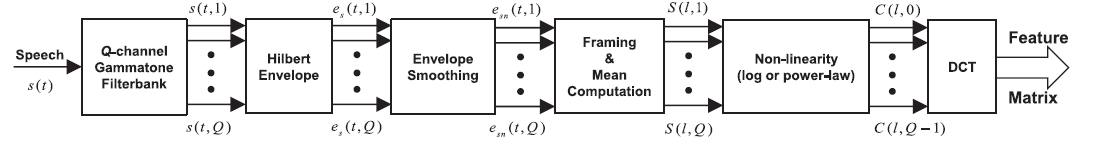

Este se compone de 5 bloques:

- Se calculan Q canales del banco del filtro gammatone
- A cada uno de los Q canales se le calcula la envolvente de Hilbert
- Cada una de las envolventes pasa por un filtrado para suavizar estas señales
- Se hace un enventanado y a estas se le calcula la media
- Se calcula la no lineadidad
- Finalmente se calcula la transformada discreta del coseno


Para obtener los filtros gammatone se utilizó el código de esta página: https://www.audiocontentanalysis.org/code/helper-functions/gammatone-filterbank-2/

In [ ]:
pip install speechpy

In [ ]:
import numpy as np
from scipy.io.wavfile import read
from scipy.signal import butter,filtfilt, hilbert, lfilter, resample
from scipy.fftpack import dct
import os
from scipy.stats import skew, kurtosis
from speechpy.processing import cmvn

# see function mfcc.m from Slaneys Auditory Toolbox (Matlab)
def ToolGammatoneFb(afAudioData, f_s, iNumBands=20, f_low=100):

    # initialization
    fEarQ = 9.26449
    fBW = 24.7
    iOrder = 1
    T = 1 / f_s

    # allocate output memory
    X = np.zeros([iNumBands, afAudioData.shape[0]])

    # compute the mid frequencies
    f_c = getMidFrequencies(f_low, f_s / 2, iNumBands, fEarQ, fBW)

    # compute the coefficients
    [afCoeffB, afCoeffA] = getCoeffs(f_c, 1.019 * 2 * np.pi * (((f_c / fEarQ)**iOrder + fBW**iOrder)**(1 / iOrder)), T)

    # do the (cascaded) filter process
    for k in range(0, iNumBands):
        X[k, :] = afAudioData
        for j in range(0, 4):
            X[k, :] = lfilter(afCoeffB[j, :, k], afCoeffA[j, :, k], X[k, :])

    return (X)


# see function ERBSpace.m from Slaneys Auditory Toolbox
def getMidFrequencies(f_low, f_hi, iNumBands, fEarQ, fBW):

    freq = np.log((f_low + fEarQ * fBW) / (f_hi + fEarQ * fBW)) / iNumBands
    f_c = np.exp(np.arange(1, iNumBands + 1) * freq)
    f_c = -(fEarQ * fBW) + f_c * (f_hi + fEarQ * fBW)

    return (f_c)


# see function MakeERBFilters.m from Slaneys Auditory Toolbox
def getCoeffs(f_c, B, T):

    fCos = np.cos(2 * f_c * np.pi * T)
    fSin = np.sin(2 * f_c * np.pi * T)
    fExp = np.exp(B * T)
    fSqrtA = 2 * np.sqrt(3 + 2**(3 / 2))
    fSqrtS = 2 * np.sqrt(3 - 2**(3 / 2))

    A0 = T
    A2 = 0
    B0 = 1
    B1 = -2 * fCos / fExp
    B2 = np.exp(-2 * B * T)

    A11 = -(2 * T * fCos / fExp + fSqrtA * T * fSin / fExp) / 2
    A12 = -(2 * T * fCos / fExp - fSqrtA * T * fSin / fExp) / 2
    A13 = -(2 * T * fCos / fExp + fSqrtS * T * fSin / fExp) / 2
    A14 = -(2 * T * fCos / fExp - fSqrtS * T * fSin / fExp) / 2

    fSqrtA = np.sqrt(3 + 2**(3 / 2))
    fSqrtS = np.sqrt(3 - 2**(3 / 2))
    fArg = (f_c * np.pi * T) * 1j

    fExp1 = 2 * np.exp(4 * fArg)
    fExp2 = 2 * np.exp(-(B * T) + 2 * fArg)

    afGain = np.abs((-fExp1 * T + fExp2 * T * (fCos - fSqrtS * fSin)) *
                    (-fExp1 * T + fExp2 * T * (fCos + fSqrtS * fSin)) *
                    (-fExp1 * T + fExp2 * T * (fCos - fSqrtA * fSin)) *
                    (-fExp1 * T + fExp2 * T * (fCos + fSqrtA * fSin)) /
                    (-2 / np.exp(2 * B * T) - fExp1 + (2 + fExp1) / fExp)**4)

    # this is Slaney's compact format - now resort into 3D Matrices
    # fcoefs = [A0*ones(length(f_c),1) A11 A12 A13 A14 A2*ones(length(f_c),1) B0*ones(length(f_c),1) B1 B2 afGain];

    afCoeffB = np.zeros([4, 3, B.size])
    afCoeffA = np.zeros([4, 3, B.size])

    for k in range(0, B.size):
        afCoeffB[0, :, k] = [A0, A11[k], A2] / afGain[k]
        afCoeffA[0, :, k] = [B0, B1[k], B2[k]]

        afCoeffB[1, :, k] = [A0, A12[k], A2]
        afCoeffA[1, :, k] = [B0, B1[k], B2[k]]

        afCoeffB[2, :, k] = [A0, A13[k], A2]
        afCoeffA[2, :, k] = [B0, B1[k], B2[k]]

        afCoeffB[3, :, k] = [A0, A14[k], A2]
        afCoeffA[3, :, k] = [B0, B1[k], B2[k]]

    return (afCoeffB, afCoeffA)

def butter_lowpass_filter(data, cutoff, fs, order):
    normal_cutoff = cutoff / nyq_rate
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

PARAM_TYPE = np.float32
def compute_delta(features,
                  win=3,
                  method='filter',
                  filt=np.array([.25, .5, .25, 0, -.25, -.5, -.25])):
    """features is a 2D-ndarray  each row of features is a a frame
    
    :param features: the feature frames to compute the delta coefficients
    :param win: parameter that set the length of the computation window.
            The size of the window is (win x 2) + 1
    :param method: method used to compute the delta coefficients
        can be diff or filter
    :param filt: definition of the filter to use in "filter" mode, default one
        is similar to SPRO4:  filt=numpy.array([.2, .1, 0, -.1, -.2])
        
    :return: the delta coefficients computed on the original features.
    """
    # First and last features are appended to the begining and the end of the 
    # stream to avoid border effect
    x = np.zeros((features.shape[0] + 2 * win, features.shape[1]), dtype=PARAM_TYPE)
    x[:win, :] = features[0, :]
    x[win:-win, :] = features
    x[-win:, :] = features[-1, :]

    delta = np.zeros(x.shape, dtype=PARAM_TYPE)

    if method == 'diff':
        filt = np.zeros(2 * win + 1, dtype=PARAM_TYPE)
        filt[0] = -1
        filt[-1] = 1

    for i in range(features.shape[1]):
        delta[:, i] = np.convolve(features[:, i], filt)

    return delta[win:-win, :]

def shifted_delta_cepstral(cep, d=1, p=3, k=7):
    """
    Compute the Shifted-Delta-Cepstral features for language identification
    
    :param cep: matrix of feature, 1 vector per line
    :param d: represents the time advance and delay for the delta computation
    :param k: number of delta-cepstral blocks whose delta-cepstral 
       coefficients are stacked to form the final feature vector
    :param p: time shift between consecutive blocks.
    
    return: cepstral coefficient concatenated with shifted deltas
    """

    y = np.r_[np.resize(cep[0, :], (d, cep.shape[1])),
                 cep,
                 np.resize(cep[-1, :], (k * 3 + d, cep.shape[1]))]

    delta = compute_delta(y, win=d, method='diff')
    sdc = np.empty((cep.shape[0], cep.shape[1] * k))

    idx = np.zeros(delta.shape[0], dtype='bool')
    for ii in range(k):
        idx[d + ii * p] = True
    for ff in range(len(cep)):
        sdc[ff, :] = delta[idx, :].reshape(1, -1)
        idx = np.roll(idx, 1)
    return np.hstack((cep, sdc))

tamVentana=25e-3
tamSolape=10e-3
matrix_explosiones=[]

ruta="/content/drive/My Drive/rep1A/pd"
lista_audios_disparos=os.listdir(ruta)
matris_disparos=[]

for i in range(len(lista_audios_disparos)):
    file_audio=(ruta+"/"+lista_audios_disparos[i])
    fs, x=read(file_audio) 
    if len(np.shape(x))>1:
      x=(x[:,0] + x[:,1]) / 2
    x=NormDC(x)
    new_fs=16000
    number_of_samples = round(len(x) * float(new_fs) / fs)
    x = resample(x, number_of_samples)
    #t=np.arange(0, float(len(x))/fs, 1.0/fs)

    signal_Gammatone=ToolGammatoneFb(x,new_fs,iNumBands=32, f_low=200)
    channels=[]
    for j in range(len(signal_Gammatone)):
        analytic_signal = hilbert(signal_Gammatone[j])
        signal_envelope = np.abs(analytic_signal)

        fc=20
        nyq_rate=new_fs/2.0
        order=2
        #signal_filter=butter_lowpass_filter(signal_envelope, fc, new_fs, order)
        ventanas=ventana_audio(signal_envelope,tamVentana,tamSolape,new_fs)

        # Se calcula la media por ventana, diferente a la hecha en los MFCCs, por lo que en cada audio
        # la longitud de este vector varía dependiendo de la duración del audio
        signal_media=np.mean(ventanas,axis=1)
        
        
        signal_Non_linearity=np.power(signal_media,1/15)
        signal_DCT=dct(signal_Non_linearity)
        channels.append(signal_DCT)
        print(lista_audios_disparos[i],"Canal: "+str(j))

    # Se usa la función shifted_delta_cepstral para organizar los datos y todos estos tengan la misma longitud 
    sdc=shifted_delta_cepstral(np.array(channels[:7]).T)
        
    print(lista_audios_disparos[i])
    
    # Una vez los datos tienen la misma longitud se sacan los estadísticos 
    m=np.mean(sdc,axis=0)
    d=np.std(sdc,axis=0)
    s=skew(sdc,axis=0)
    k=kurtosis(sdc,axis=0)
    
    medidas=np.concatenate((m,d,s,k))
    matris_disparos.append(medidas)

# Finalmente se guarda la extracción de características 
print(np.shape(matris_disparos))
np.savetxt("PD_rep1A_MHEC.txt",matris_disparos)

AVPEPUDEA0001a1.wav Canal: 0
AVPEPUDEA0001a1.wav Canal: 1
AVPEPUDEA0001a1.wav Canal: 2
AVPEPUDEA0001a1.wav Canal: 3
AVPEPUDEA0001a1.wav Canal: 4
AVPEPUDEA0001a1.wav Canal: 5
AVPEPUDEA0001a1.wav Canal: 6
AVPEPUDEA0001a1.wav Canal: 7
AVPEPUDEA0001a1.wav Canal: 8
AVPEPUDEA0001a1.wav Canal: 9
AVPEPUDEA0001a1.wav Canal: 10
AVPEPUDEA0001a1.wav Canal: 11
AVPEPUDEA0001a1.wav Canal: 12
AVPEPUDEA0001a1.wav Canal: 13
AVPEPUDEA0001a1.wav Canal: 14
AVPEPUDEA0001a1.wav Canal: 15
AVPEPUDEA0001a1.wav Canal: 16
AVPEPUDEA0001a1.wav Canal: 17
AVPEPUDEA0001a1.wav Canal: 18
AVPEPUDEA0001a1.wav Canal: 19
AVPEPUDEA0001a1.wav Canal: 20
AVPEPUDEA0001a1.wav Canal: 21
AVPEPUDEA0001a1.wav Canal: 22
AVPEPUDEA0001a1.wav Canal: 23
AVPEPUDEA0001a1.wav Canal: 24
AVPEPUDEA0001a1.wav Canal: 25
AVPEPUDEA0001a1.wav Canal: 26
AVPEPUDEA0001a1.wav Canal: 27
AVPEPUDEA0001a1.wav Canal: 28
AVPEPUDEA0001a1.wav Canal: 29
AVPEPUDEA0001a1.wav Canal: 30
AVPEPUDEA0001a1.wav Canal: 31
AVPEPUDEA0001a1.wav
AVPEPUDEA0002a1.wav Canal: 0
A

Este algoritmo se calcula para las 3 base de datos diferentes, teniendo así 6 archivos .txt que hacen referencia a la extracción de características de los MFFcs para cada una de la base de datos tanto para los HC (Healthy Control) como para los PD (Parkinson disease).

- PD_readtext_MHEC.txt
- HC_readtext_MHEC.txt
- PD_monologue_MHEC.txt
- HC_monologue_MHEC.txt
- PD_REP1A_MHEC.txt
- HC_REP1A_MHEC.txt

**Clasificación**

Una vez obtenidas todas las características (**MFCC** y **MHEC**) en las 3 bases de datos, procedemos a entrenar una SVM para discriminar pacientes sanos o pacientes con Parkinson en cada una de las bases de datos.

Para el clasificador SVM hacemos uso de la **cross-validation k-fold**, que básicamente consiste en dividir la base de datos en K subconjuntos. Uno de los subconjuntos se utiliza como datos de prueba y el resto (K-1) como datos de entrenamiento. El proceso de validación cruzada es repetido durante k iteraciones, con cada uno de los posibles subconjuntos de datos de prueba, evitando así que el sistema quede sobre ajustado, la siguiente imagen ilustra mejor este procedimiento.

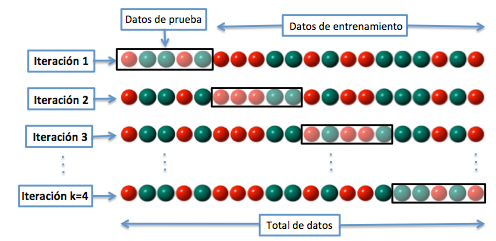

Por cada una de las iteraciones de la **cross-validation** hacemos uso del **GridSearch** para ver los parámetros con el que mejor se comporta el clasificador usando un kernel **rbf** con parámetros C [0.01, 0.1, 0.2, 0.35, 0.5, 0.75, 1, 1.5, 3, 5, 7.5, 10] y gamma [0.001, 0.005, 0.0075,0.01,0.05, 0.075, 0.02, 0.35, 0.5, 0.75, 1] y un kernel **linear** con parámetros C [0.01, 0.1, 0.2, 0.35, 0.5, 0.75, 1, 1.5, 3, 5, 7.5, 10]

Finalmente para evaluar el comportamiento del sistema hacemos uso de la **Matriz de confusión** y de la **Cuerva ROC** que es una representación gráfica de la sensibilidad frente a la especificidad para un sistema clasificador binario según se varía el umbral de discriminación


0.5900000000000001
CCR = 0.5900000000000001 ± 0.16401219466856723
S = 0.5800000000000001 ± 0.208806130178211
E = 0.6 ± 0.23664319132398465


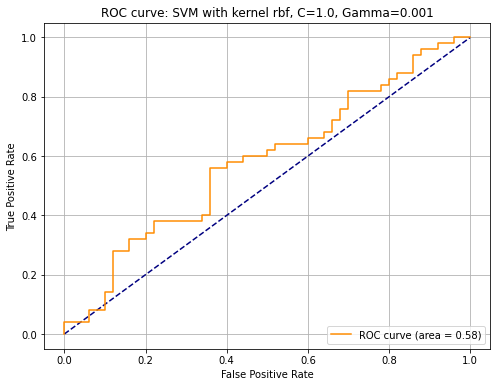

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


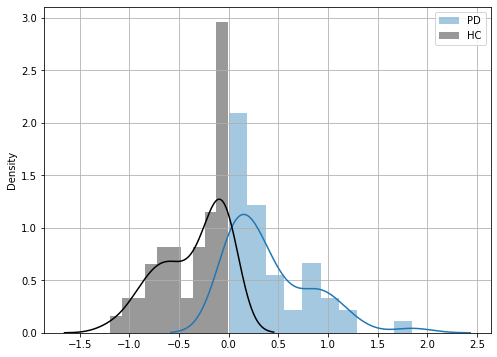

0.55
CCR = 0.55 ± 0.13601470508735444
S = 0.5399999999999999 ± 0.18
E = 0.56 ± 0.17435595774162696


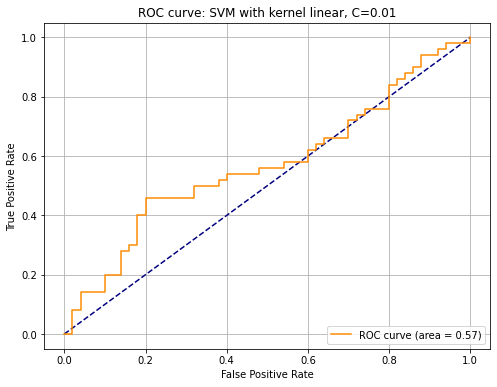

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


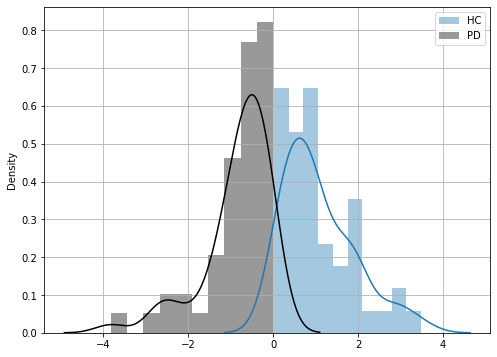

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
import seaborn as sns

# Se lee el par de archivos .txt, para HC y PD

matris_HC=np.loadtxt("/content/drive/MyDrive/Señales III/Data/HC_readtext_MHEC.txt")
matris_PD=np.loadtxt("/content/drive/MyDrive/Señales III/Data/PD_readtext_MHEC.txt")

#matris_HC=np.loadtxt("/content/drive/MyDrive/Señales III/Data/HC_readtext_MFCC.txt")
#matris_PD=np.loadtxt("/content/drive/MyDrive/Señales III/Data/PD_readtext_MFCC.txt")

#matris_HC=np.loadtxt("/content/drive/MyDrive/Señales III/Data/HC_monologue_MHEC.txt")
#matris_PD=np.loadtxt("/content/drive/MyDrive/Señales III/Data/PD_monologue_MFCC.txt")

#matris_HC=np.loadtxt("/content/drive/MyDrive/Señales III/Data/HC_monologue_MFCC.txt")
#matris_PD=np.loadtxt("/content/drive/MyDrive/Señales III/Data/PD_monologue_MFCC.txt")

#matris_HC=np.loadtxt("/content/drive/MyDrive/Señales III/Data/HC_REP1A_MHEC.txt")
#matris_PD=np.loadtxt("/content/drive/MyDrive/Señales III/Data/PD_REP1A_MHEC.txt")

#matris_HC=np.loadtxt("/content/drive/MyDrive/Señales III/Data/HC_REP1A_MFCC.txt")
#matris_PD=np.loadtxt("/content/drive/MyDrive/Señales III/Data/PD_REP1A_MFCC.txt")

X=np.concatenate((matris_HC,matris_PD))
y=np.concatenate((np.zeros(len(matris_HC)),np.ones(len(matris_PD))))


#scaler=StandardScaler()
#scaler.fit(X)
#X=scaler.transform(X)

#pca=PCA(n_components=0.9)
#X=pca.fit_transform(X)
#print(pca.explained_variance_ratio_.cumsum())
#print()



"""
    Kernel rbf
"""
parameters = {'kernel':['rbf'], 'C':[0.01, 0.1, 0.2, 0.35, 0.5, 0.75, 1, 1.5, 3, 5, 7.5, 10], "gamma":[0.001, 0.005, 0.0075,0.01,0.05, 0.075, 0.02, 0.35, 0.5, 0.75, 1]}

skf=StratifiedKFold(n_splits=10)
skf.get_n_splits(X,y)

n_CCR=[]
n_S=[]
n_E=[]
i=0

lista_C=[]
lista_gamma=[]
lista_pred=[]
lista_test=[]
lista_decision=[]

for train_index, test_index in skf.split(X, y):
    # Segmentación de las train y test
    x_train, x_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    scaler=StandardScaler()
    scaler.fit(x_train)
    x_train=scaler.transform(x_train)
    x_test=scaler.transform(x_test)
    
    # Hiperplanos
    svc = svm.SVC()
    clf=GridSearchCV(svc,parameters, cv=9)
    clf.fit(x_train,y_train)
    C_ideal=clf.best_estimator_.C
    Gamma_ideal=clf.best_estimator_.gamma
    lista_C.append(C_ideal)
    lista_gamma.append(Gamma_ideal)
    
    # Entrenamiento
    clf = svm.SVC(C=C_ideal, gamma=Gamma_ideal, kernel = "rbf")
    clf.fit(x_train,y_train)
    y_pred=clf.predict(x_test)
    
    lista_decision.append(clf.decision_function(x_test))
    lista_pred.append(y_pred)
    lista_test.append(y_test)
    i=i+1
    
    M=confusion_matrix(y_test, y_pred)
    TN=M[0][0]
    FN=M[1][0]
    TP=M[1][1]
    FP=M[0][1]
    CCR=(TP+TN)/(TP+FN+FP+TN)
    S=TP/(TP+FN)
    E=TN/(FP+TN)
    TN=M[0][0]
    FN=M[1][0]
    TP=M[1][1]
    FP=M[0][1]
    n_CCR.append(CCR)
    n_S.append(S)
    n_E.append(E)
    i=i+1
    
lista_pred=np.hstack(lista_pred)
lista_test=np.hstack(lista_test)
lista_decision=np.hstack(lista_decision)

CCR=np.mean(n_CCR)
S=np.mean(n_S)
E=np.mean(n_E)
d_CCR=np.std(n_CCR)
d_S=np.std(n_S)
d_E=np.std(n_E)

print(np.mean(n_CCR))
print("CCR =",CCR,"±",d_CCR)
print("S =",S,"±",d_S)
print("E =",E,"±",d_E)

fpr, tpr, thresholds = roc_curve(lista_test,lista_decision)
roc_auc=auc(fpr,tpr)

plt.figure(figsize=(8,6))
plt.plot([0, 1], [0, 1], color='navy', linestyle="--")
plt.plot(fpr, tpr, color='darkorange', label="ROC curve (area = %0.2f)" % roc_auc)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
C, indices = np.unique(lista_C, return_inverse=True) 
C=C[np.argmax(np.bincount(indices))] 
Gamma, indices = np.unique(lista_gamma, return_inverse=True) 
Gamma=Gamma[np.argmax(np.bincount(indices))]
s="ROC curve: SVM with kernel rbf, C="+str(C)+", Gamma="+str(Gamma)
plt.title(s)
plt.legend(loc="lower right")
plt.grid()
plt.show()

lista_HC=[]
lista_PD=[]
for pos in range(len(lista_test)):
    if lista_pred[pos]==1:
        lista_HC.append(lista_decision[pos])
    else:
        lista_PD.append(lista_decision[pos])
        
plt.figure(figsize=(8,6))
sns.distplot(lista_HC, bins=10, label="PD")
sns.distplot(lista_PD, bins=10, label="HC", color="k")
plt.legend()
plt.grid()
plt.show()

"""
    Kernel lineal
"""


parameters = {'kernel':['linear'], 'C':[0.01, 0.1, 0.2, 0.35, 0.5, 0.75, 1, 1.5, 3, 5, 7.5, 10]}

skf=StratifiedKFold(n_splits=10)
skf.get_n_splits(X,y)

n_CCR=[]
n_S=[]
n_E=[]
i=0

lista_C=[]
lista_pred=[]
lista_test=[]
lista_decision=[]

for train_index, test_index in skf.split(X, y):
    # Segmentación de las train y test
    x_train, x_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    scaler=StandardScaler()
    scaler.fit(x_train)
    x_train=scaler.transform(x_train)
    x_test=scaler.transform(x_test)
    
    # Hiperplanos
    svc = svm.SVC()
    clf=GridSearchCV(svc,parameters, cv=9)
    clf.fit(x_train,y_train)
    C_ideal=clf.best_estimator_.C
    lista_C.append(C_ideal)
    
    # Entrenamiento
    clf = svm.SVC(C=C_ideal, kernel = "linear")
    clf.fit(x_train,y_train)
    y_pred=clf.predict(x_test)
    
    lista_decision.append(clf.decision_function(x_test))
    lista_pred.append(y_pred)
    lista_test.append(y_test)
    i=i+1
    
    M=confusion_matrix(y_test, y_pred)
    TN=M[0][0]
    FN=M[1][0]
    TP=M[1][1]
    FP=M[0][1]
    CCR=(TP+TN)/(TP+FN+FP+TN)
    S=TP/(TP+FN)
    E=TN/(FP+TN)
    TN=M[0][0]
    FN=M[1][0]
    TP=M[1][1]
    FP=M[0][1]
    n_CCR.append(CCR)
    n_S.append(S)
    n_E.append(E)
    i=i+1
    
lista_pred=np.hstack(lista_pred)
lista_test=np.hstack(lista_test)
lista_decision=np.hstack(lista_decision)

CCR=np.mean(n_CCR)
S=np.mean(n_S)
E=np.mean(n_E)
d_CCR=np.std(n_CCR)
d_S=np.std(n_S)
d_E=np.std(n_E)

print(np.mean(n_CCR))
print("CCR =",CCR,"±",d_CCR)
print("S =",S,"±",d_S)
print("E =",E,"±",d_E)

fpr, tpr, thresholds = roc_curve(lista_test,lista_decision)
roc_auc=auc(fpr,tpr)

plt.figure(figsize=(8,6))
plt.plot([0, 1], [0, 1], color='navy', linestyle="--")
plt.plot(fpr, tpr, color='darkorange', label="ROC curve (area = %0.2f)" % roc_auc)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
C, indices = np.unique(lista_C, return_inverse=True) 
C=C[np.argmax(np.bincount(indices))]
s="ROC curve: SVM with kernel linear, C="+str(C_ideal)
plt.title(s)
plt.legend(loc="lower right")
plt.grid()
plt.show()

lista_HC=[]
lista_PD=[]

for pos in range(len(lista_test)):
    if lista_pred[pos]==1:
        lista_HC.append(lista_decision[pos])
    else:
        lista_PD.append(lista_decision[pos])
        
plt.figure(figsize=(8,6))
sns.distplot(lista_HC, bins=10, label="HC")
sns.distplot(lista_PD, bins=10, label="PD", color="k")
plt.legend()
plt.grid()
plt.show()


Para **readtext** con los **MHEC** el hiperplano que tuvo mejor desempeño fue el rbf con C=1 y gamma=0.001 con un CCR de 0.59

0.61
CCR = 0.61 ± 0.13
S = 0.58 ± 0.22715633383201095
E = 0.64 ± 0.17435595774162693


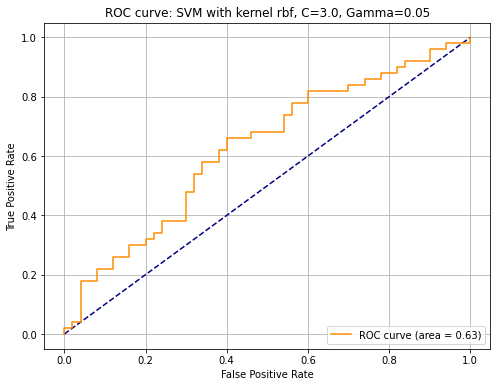

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


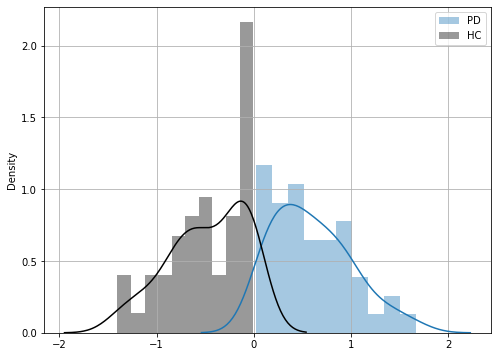

0.51
CCR = 0.51 ± 0.09433981132056603
S = 0.5599999999999999 ± 0.29393876913398137
E = 0.4600000000000001 ± 0.2009975124224178


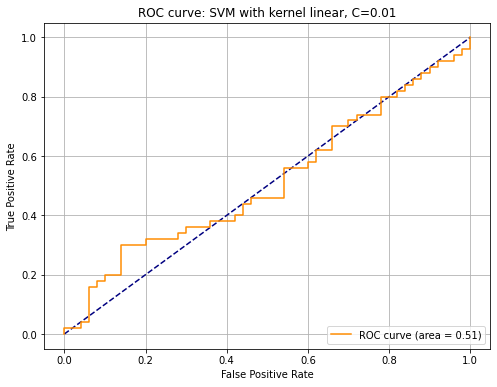

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


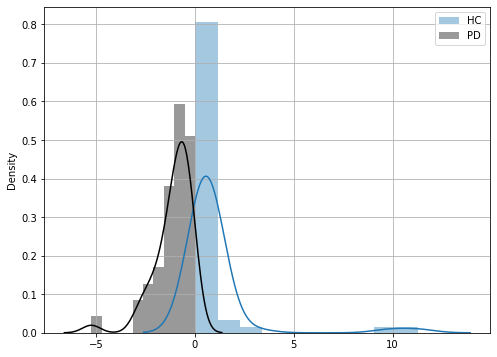

In [ ]:
#matris_HC=np.loadtxt("/content/drive/MyDrive/Señales III/Data/HC_readtext_MHEC.txt")
#matris_PD=np.loadtxt("/content/drive/MyDrive/Señales III/Data/PD_readtext_MHEC.txt")

matris_HC=np.loadtxt("/content/drive/MyDrive/Señales III/Data/HC_readtext_MFCC.txt")
matris_PD=np.loadtxt("/content/drive/MyDrive/Señales III/Data/PD_readtext_MFCC.txt")

#matris_HC=np.loadtxt("/content/drive/MyDrive/Señales III/Data/HC_monologue_MHEC.txt")
#matris_PD=np.loadtxt("/content/drive/MyDrive/Señales III/Data/PD_monologue_MFCC.txt")

#matris_HC=np.loadtxt("/content/drive/MyDrive/Señales III/Data/HC_monologue_MFCC.txt")
#matris_PD=np.loadtxt("/content/drive/MyDrive/Señales III/Data/PD_monologue_MFCC.txt")

#matris_HC=np.loadtxt("/content/drive/MyDrive/Señales III/Data/HC_REP1A_MHEC.txt")
#matris_PD=np.loadtxt("/content/drive/MyDrive/Señales III/Data/PD_REP1A_MHEC.txt")

#matris_HC=np.loadtxt("/content/drive/MyDrive/Señales III/Data/HC_REP1A_MFCC.txt")
#matris_PD=np.loadtxt("/content/drive/MyDrive/Señales III/Data/PD_REP1A_MFCC.txt")


X=np.concatenate((matris_HC,matris_PD))
y=np.concatenate((np.zeros(len(matris_HC)),np.ones(len(matris_PD))))


#scaler=StandardScaler()
#scaler.fit(X)
#X=scaler.transform(X)

#pca=PCA(n_components=0.9)
#X=pca.fit_transform(X)
#print(pca.explained_variance_ratio_.cumsum())
#print()



"""
    Kernel rbf
"""
parameters = {'kernel':['rbf'], 'C':[0.01, 0.1, 0.2, 0.35, 0.5, 0.75, 1, 1.5, 3, 5, 7.5, 10], "gamma":[0.001, 0.005, 0.0075,0.01,0.05, 0.075, 0.02, 0.35, 0.5, 0.75, 1]}

skf=StratifiedKFold(n_splits=10)
skf.get_n_splits(X,y)

n_CCR=[]
n_S=[]
n_E=[]
i=0

lista_C=[]
lista_gamma=[]
lista_pred=[]
lista_test=[]
lista_decision=[]

for train_index, test_index in skf.split(X, y):
    # Segmentación de las train y test
    x_train, x_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    scaler=StandardScaler()
    scaler.fit(x_train)
    x_train=scaler.transform(x_train)
    x_test=scaler.transform(x_test)
    
    # Hiperplanos
    svc = svm.SVC()
    clf=GridSearchCV(svc,parameters, cv=9)
    clf.fit(x_train,y_train)
    C_ideal=clf.best_estimator_.C
    Gamma_ideal=clf.best_estimator_.gamma
    lista_C.append(C_ideal)
    lista_gamma.append(Gamma_ideal)
    
    # Entrenamiento
    clf = svm.SVC(C=C_ideal, gamma=Gamma_ideal, kernel = "rbf")
    clf.fit(x_train,y_train)
    y_pred=clf.predict(x_test)
    
    lista_decision.append(clf.decision_function(x_test))
    lista_pred.append(y_pred)
    lista_test.append(y_test)
    i=i+1
    
    M=confusion_matrix(y_test, y_pred)
    TN=M[0][0]
    FN=M[1][0]
    TP=M[1][1]
    FP=M[0][1]
    CCR=(TP+TN)/(TP+FN+FP+TN)
    S=TP/(TP+FN)
    E=TN/(FP+TN)
    TN=M[0][0]
    FN=M[1][0]
    TP=M[1][1]
    FP=M[0][1]
    n_CCR.append(CCR)
    n_S.append(S)
    n_E.append(E)
    i=i+1
    
lista_pred=np.hstack(lista_pred)
lista_test=np.hstack(lista_test)
lista_decision=np.hstack(lista_decision)

CCR=np.mean(n_CCR)
S=np.mean(n_S)
E=np.mean(n_E)
d_CCR=np.std(n_CCR)
d_S=np.std(n_S)
d_E=np.std(n_E)

print(np.mean(n_CCR))
print("CCR =",CCR,"±",d_CCR)
print("S =",S,"±",d_S)
print("E =",E,"±",d_E)

fpr, tpr, thresholds = roc_curve(lista_test,lista_decision)
roc_auc=auc(fpr,tpr)

plt.figure(figsize=(8,6))
plt.plot([0, 1], [0, 1], color='navy', linestyle="--")
plt.plot(fpr, tpr, color='darkorange', label="ROC curve (area = %0.2f)" % roc_auc)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
C, indices = np.unique(lista_C, return_inverse=True) 
C=C[np.argmax(np.bincount(indices))] 
Gamma, indices = np.unique(lista_gamma, return_inverse=True) 
Gamma=Gamma[np.argmax(np.bincount(indices))]
s="ROC curve: SVM with kernel rbf, C="+str(C)+", Gamma="+str(Gamma)
plt.title(s)
plt.legend(loc="lower right")
plt.grid()
plt.show()

lista_HC=[]
lista_PD=[]
for pos in range(len(lista_test)):
    if lista_pred[pos]==1:
        lista_HC.append(lista_decision[pos])
    else:
        lista_PD.append(lista_decision[pos])
        
plt.figure(figsize=(8,6))
sns.distplot(lista_HC, bins=10, label="PD")
sns.distplot(lista_PD, bins=10, label="HC", color="k")
plt.legend()
plt.grid()
plt.show()

"""
    Kernel lineal
"""


parameters = {'kernel':['linear'], 'C':[0.01, 0.1, 0.2, 0.35, 0.5, 0.75, 1, 1.5, 3, 5, 7.5, 10]}

skf=StratifiedKFold(n_splits=10)
skf.get_n_splits(X,y)

n_CCR=[]
n_S=[]
n_E=[]
i=0

lista_C=[]
lista_pred=[]
lista_test=[]
lista_decision=[]

for train_index, test_index in skf.split(X, y):
    # Segmentación de las train y test
    x_train, x_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    scaler=StandardScaler()
    scaler.fit(x_train)
    x_train=scaler.transform(x_train)
    x_test=scaler.transform(x_test)
    
    # Hiperplanos
    svc = svm.SVC()
    clf=GridSearchCV(svc,parameters, cv=9)
    clf.fit(x_train,y_train)
    C_ideal=clf.best_estimator_.C
    lista_C.append(C_ideal)
    
    # Entrenamiento
    clf = svm.SVC(C=C_ideal, kernel = "linear")
    clf.fit(x_train,y_train)
    y_pred=clf.predict(x_test)
    
    lista_decision.append(clf.decision_function(x_test))
    lista_pred.append(y_pred)
    lista_test.append(y_test)
    i=i+1
    
    M=confusion_matrix(y_test, y_pred)
    TN=M[0][0]
    FN=M[1][0]
    TP=M[1][1]
    FP=M[0][1]
    CCR=(TP+TN)/(TP+FN+FP+TN)
    S=TP/(TP+FN)
    E=TN/(FP+TN)
    TN=M[0][0]
    FN=M[1][0]
    TP=M[1][1]
    FP=M[0][1]
    n_CCR.append(CCR)
    n_S.append(S)
    n_E.append(E)
    i=i+1
    
lista_pred=np.hstack(lista_pred)
lista_test=np.hstack(lista_test)
lista_decision=np.hstack(lista_decision)

CCR=np.mean(n_CCR)
S=np.mean(n_S)
E=np.mean(n_E)
d_CCR=np.std(n_CCR)
d_S=np.std(n_S)
d_E=np.std(n_E)

print(np.mean(n_CCR))
print("CCR =",CCR,"±",d_CCR)
print("S =",S,"±",d_S)
print("E =",E,"±",d_E)

fpr, tpr, thresholds = roc_curve(lista_test,lista_decision)
roc_auc=auc(fpr,tpr)

plt.figure(figsize=(8,6))
plt.plot([0, 1], [0, 1], color='navy', linestyle="--")
plt.plot(fpr, tpr, color='darkorange', label="ROC curve (area = %0.2f)" % roc_auc)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
C, indices = np.unique(lista_C, return_inverse=True) 
C=C[np.argmax(np.bincount(indices))]
s="ROC curve: SVM with kernel linear, C="+str(C_ideal)
plt.title(s)
plt.legend(loc="lower right")
plt.grid()
plt.show()

lista_HC=[]
lista_PD=[]

for pos in range(len(lista_test)):
    if lista_pred[pos]==1:
        lista_HC.append(lista_decision[pos])
    else:
        lista_PD.append(lista_decision[pos])
        
plt.figure(figsize=(8,6))
sns.distplot(lista_HC, bins=10, label="HC")
sns.distplot(lista_PD, bins=10, label="PD", color="k")
plt.legend()
plt.grid()
plt.show()

Para **readtext** con los **MFCC** el hiperplano que tuvo mejor desempeño fue el rbf con C=3 y gamma=0.05 con una CCR de 0.61


Con la distribución gaussiana podemos también corroborar los datos datos por la curva ROC y la matriz de confusión, ya que viendo la distribución de los datos podemos ver o intuir qué tan fácil se puede discriminar entre pacientes sanos y pacientes con Parkinson.

Para el resto de datos se hicieron aparte y se sintetizaron en la siguiente tabla:

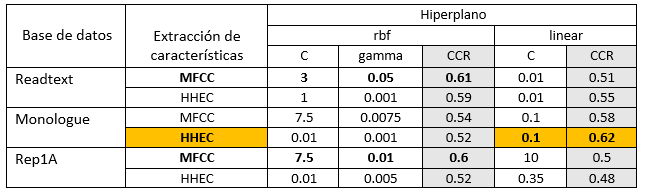

Se puede ver que la diferencia entre los 2 diferentes métodos de extracción de características no es muy significativa, lo que podemos destacar acá es en la base de datos Monologue o Readtext, tienden a tener un mejor resultado, esto posiblemente debido a que tienen una mayor duración y contienen gran variedad de palabras además de que en el monologue son las personas contando qué es lo que hacen en un día cotidiano.

Como en la extracción de características de los MFCCs se tienen 48 datos por audio y en los MHECs 224 por audio, se considera pertinente reducir esta cantidad de características y evaluar su desempeño, para esto se opta por utilizar PCA teniendo en cuenta el 90% de la desviasión.

El resultado de realizar la clasificación usando PCA se resume en la siguiente tabla:

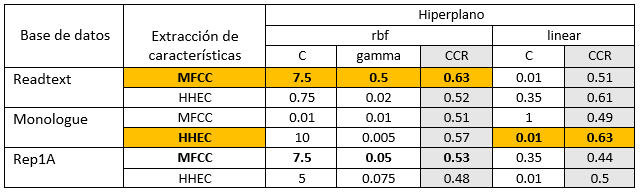

Usando PCA y logrando así reducir el problema del sobredimensionamiento, no se ve una aparente mejoría a la hora de entrenar la SVM, aunque se obtuvo una mejor ACC aplicando este método, teniendo una ACC de 0.63 tanto para la base de datos de monologue como readtext con los MHECs.

# Conclusiones
- Hay que buscar más en el estado del arte sobre el tipo de grabaciones a usar para ver cuál puede tener un mayor impacto a la hora de determinar si un paciente sufre o no de parkinson, por ejemplo, se puede considerar usar alguna diadococinesia (/papapa, /pataka, /kakaka), ya que estas son palabras que no tienen un significado en partircular y por lo tanto tampocro habrían algún tipo de emoción en las grabaciones, permitiendo una mejor calidad en la extracción de características de estos audios y permitieendo incluso no solo evaluar esto en pacientes hispanoahablantes si no, a toda la población en general.

- La extracción de características con los MFCCs es una gran herramienta en el área del reconocimiento de audio, ya que estas extraen las características de las componentes de una señal de audio, además de que este tiene una menor complejidad computacional en comparación a los MHECs, pero es importante la búsqueda de otros métodos de extracción de características que se concentren en zonas particulares del habla (como el tracto vocal) que faciliten la discriminación de los pacientes con parkinson, además, según los resultados de Seyed y Hansen los MHECs tienen una mayor robustés frente al ruido.
